In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('C:/Users/lisia/Downloads/Steel_industry_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [3]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df['month'] = df['date'].dt.month
# не используем год, т.к. он одинаковый
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df = df.drop('date', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  int64  
 7   WeekStatus                            35040 non-null  object 
 8   Day_of_week                           35040 non-null  object 
 9   Load_Type                             35040 non-null  object 
 10  month                                 35040 non-null  int32  
 11  hour           

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['WeekStatus'] = le.fit_transform(df['WeekStatus'])
df['Day_of_week'] = le.fit_transform(df['Day_of_week'])
df['Load_Type'] = le.fit_transform(df['Load_Type'])
df = df.astype(float)
df.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,month,hour,minute
0,3.17,2.95,0.0,0.0,73.21,100.0,900.0,0.0,1.0,0.0,1.0,0.0,15.0
1,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,0.0,1.0,0.0,1.0,0.0,30.0
2,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,0.0,1.0,0.0,1.0,0.0,45.0
3,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,0.0,1.0,0.0,1.0,1.0,0.0
4,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,0.0,1.0,0.0,1.0,1.0,15.0


<Axes: >

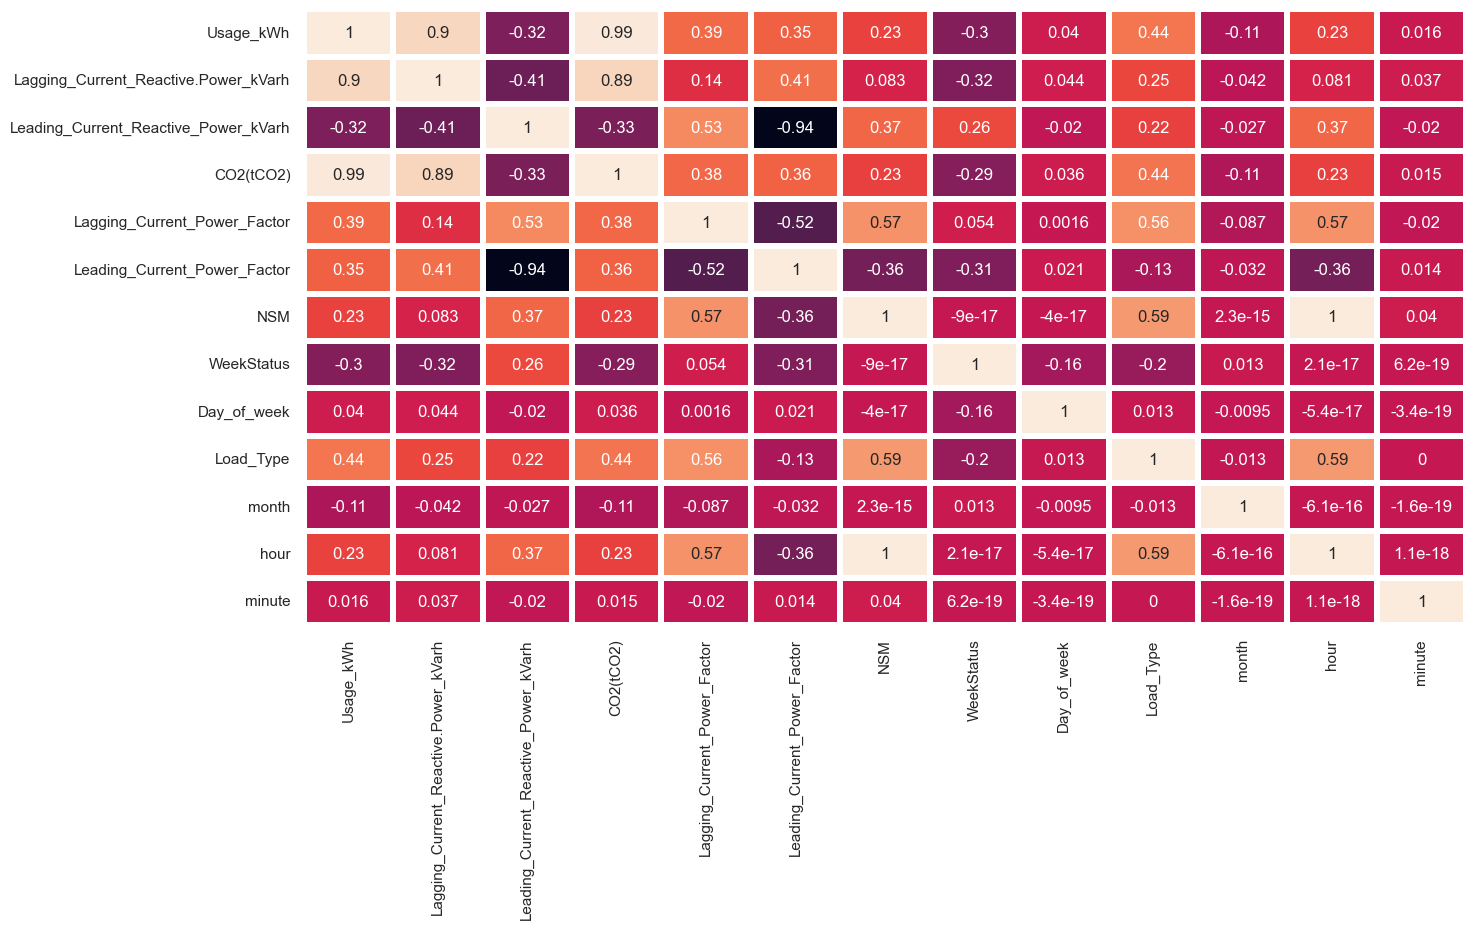

In [5]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df.corr(), annot=True, linewidths=3, cbar=False)

In [6]:
# Разбиение данных на интервалы, т.к. для расчета энтропии необходимо, чтобы все значения были категориальными.
def split_data_into_intervals(data: pd.DataFrame):
    data = data.copy()
    for i in data.columns:
        n_intervals = int(np.ceil(np.log2(data[i].count()) + 1))
        data[i] = pd.cut(data[i], n_intervals)
    return data


def calc_entropy(data: pd.DataFrame, feature: str):
    entropy = 0
    capacity = data[feature].count()
    for i in data[feature].value_counts():
        p = i / capacity
        if p == 0:
            continue
        entropy += -p * np.log2(p)
    return entropy

# Вычисление sub-entropies для каждого значения признака
def calc_conditional_entropies(data: pd.DataFrame, feature: str, target: str):
    data_values = data[feature].value_counts().sort_index()
    entropies = []
    for i in range(len(data_values)):
        target_data = data[data[feature] == data_values.index[i]]
        if target_data[target].count() == 0:
            entropies.append([data_values.iloc[i], 0])
        else:
            entropies.append([data_values.iloc[i], calc_entropy(target_data, target)])
    return entropies

def calc_information_gain(data: pd.DataFrame, feature: str, target: str):
    entropy = calc_entropy(data, target)
    conditional_entropies = calc_conditional_entropies(data, feature, target)
    for i in range(len(conditional_entropies)):
        entropy -= conditional_entropies[i][0] * conditional_entropies[i][1] / data[feature].count()
    return entropy

def calc_intrinsic_information(data: pd.DataFrame, feature: str):
    ii = 0
    for i in range(len(data[feature].value_counts())):
        d = data[feature].value_counts().iloc[i] / data[feature].count()
        if d == 0:
            continue
        ii += -d * np.log2(d)
    return ii

def calc_information_gain_ratio(data: pd.DataFrame, feature: str, target: str):
    ig = calc_information_gain(data, feature, target)
    ii = calc_intrinsic_information(data, feature)
    if ii == 0:
        return 0
    return ig / ii

df_i = split_data_into_intervals(df)
feature_cols = df_i.columns.drop('Usage_kWh')
usage_gr = {}
for i in feature_cols:
    usage_gr[i] = calc_information_gain_ratio(df_i, i, 'Usage_kWh')

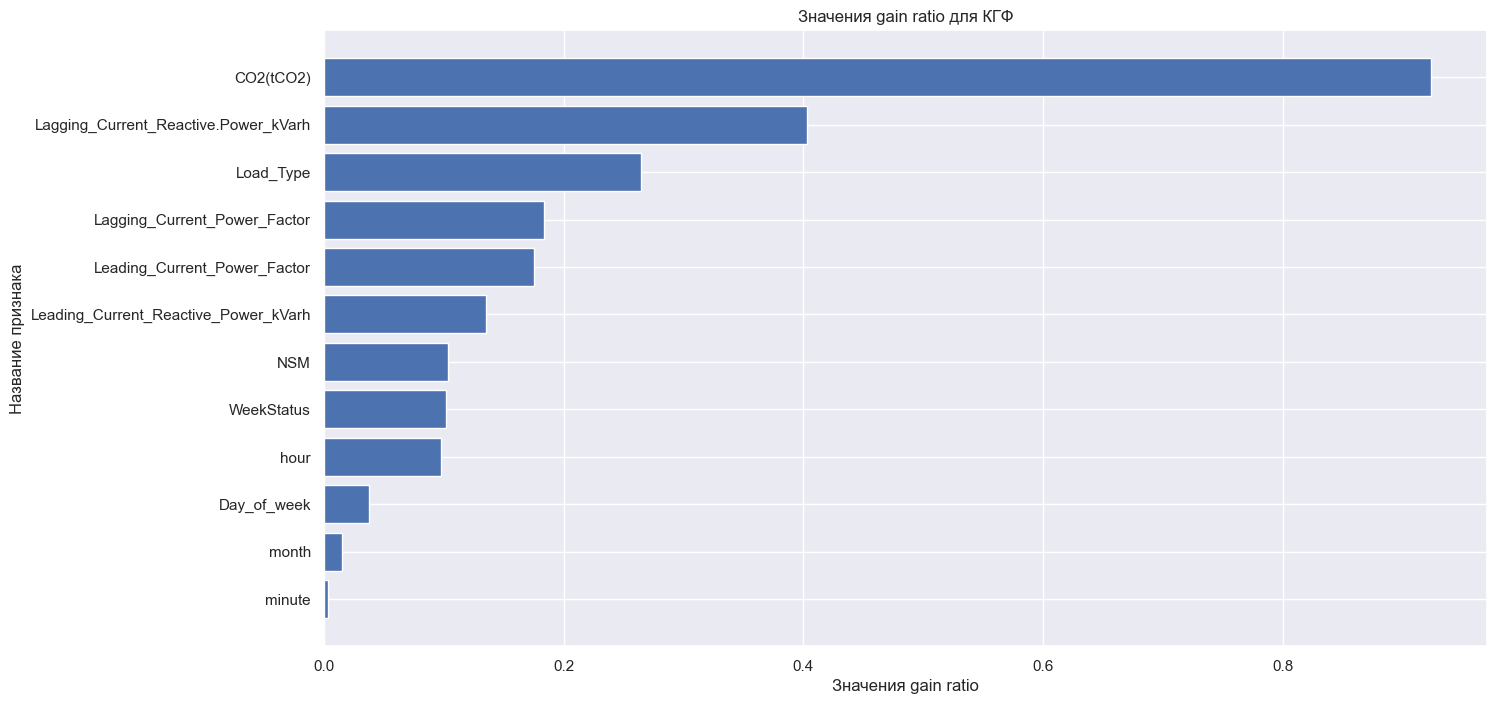

In [7]:
import matplotlib.pyplot as plt

names = list(usage_gr.keys())
values = list(usage_gr.values())

sorted_kgf_indices = sorted(range(len(values)), key=values.__getitem__)
kgf_names_sorted = [names[i] for i in sorted_kgf_indices]
kgf_values_sorted = [values[i] for i in sorted_kgf_indices]

plt.barh(kgf_names_sorted, kgf_values_sorted)
plt.title("Значения gain ratio для КГФ")
plt.xlabel("Значения gain ratio")
plt.ylabel("Название признака")
plt.show()

In [8]:
df = df.drop(['minute', 'month', 'Day_of_week', 'hour', 'WeekStatus', 'NSM'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   Load_Type                             35040 non-null  float64
dtypes: float64(7)
memory usage: 1.9 MB


In [12]:
import numpy as np
from math import sqrt

class LSTM:
    def __init__(self, steps, neurons):
        '''
        steps: number of time steps
        neurons: number of neurons in the hidden layer
        '''
        self.input = None
        self.output = None
        self.state = None
        self.lr = None
        np.random.seed(0)
        self.W_fx = np.random.uniform(-1, 1, (steps, neurons)) / sqrt(neurons)
        self.W_fh = np.random.uniform(-1, 1, (neurons, neurons)) / sqrt(neurons)
        self.b_f = np.random.uniform(-1, 1, (1, neurons)) / sqrt(neurons)
        
        self.W_ix = np.random.uniform(-1, 1, (steps, neurons)) / sqrt(neurons)
        self.W_ih = np.random.uniform(-1, 1, (neurons, neurons)) / sqrt(neurons)
        self.b_i = np.random.uniform(-1, 1, (1, neurons)) / sqrt(neurons)
        
        self.W_cx = np.random.uniform(-1, 1, (steps, neurons)) / sqrt(neurons)
        self.W_ch = np.random.uniform(-1, 1, (neurons, neurons)) / sqrt(neurons)
        self.b_c = np.random.uniform(-1, 1, (1, neurons)) / sqrt(neurons)
        
        self.W_ox = np.random.uniform(-1, 1, (steps, neurons)) / sqrt(neurons)
        self.W_oh = np.random.uniform(-1, 1, (neurons, neurons)) / sqrt(neurons)
        self.b_o = np.random.uniform(-1, 1, (1, neurons)) / sqrt(neurons)
        
        self.W_y = np.random.uniform(-1, 1, (neurons, 1)) / sqrt(neurons)
        self.b_y = np.random.uniform(-1, 1, (1, 1)) / sqrt(neurons)
        

    def forward(self, input):
        """
        x: input, shape: (window_size, number_of_features)
        state: hidden state, shape: (window_size, number_of_neurons)
        o: output, shape: (window_size, 1)
        """
        state = np.zeros((input.shape[0], self.W_fh.shape[0]))
        output = np.zeros((input.shape[0], 1))
        cell_state = np.zeros((input.shape[0], self.W_fh.shape[0]))
        for ind in range(input.shape[0]):
            max_ind = max(ind - 1, 0)
            f = self.sigmoid(input[ind] @ self.W_fx + state[max_ind] @ self.W_fh + self.b_f)
            i = self.sigmoid(input[ind] @ self.W_ix + state[max_ind] @ self.W_ih + self.b_i)
            g = np.tanh(input[ind] @ self.W_cx + state[max_ind] @ self.W_ch + self.b_c)
            o = self.sigmoid(input[ind] @ self.W_ox + state[max_ind] @ self.W_oh + self.b_o)
            
            cell_state[ind] = f * cell_state[max_ind] + i * g
            state[ind] = o * np.tanh(cell_state[ind])
            output[ind] = state[ind] @ self.W_y + self.b_y
            
        self.input = input
        self.state = state
        self.cell_state = cell_state
        self.output = output

    def backward(self, y):
        loss_grad = self.loss_grad(self.output, y)
        W_fx_grad = np.zeros_like(self.W_fx)
        W_fh_grad = np.zeros_like(self.W_fh)
        b_f_grad = np.zeros_like(self.b_f)
        
        W_ix_grad = np.zeros_like(self.W_ix)
        W_ih_grad = np.zeros_like(self.W_ih)
        b_i_grad = np.zeros_like(self.b_i)
        
        W_cx_grad = np.zeros_like(self.W_cx)
        W_ch_grad = np.zeros_like(self.W_ch)
        b_c_grad = np.zeros_like(self.b_c)
        
        W_ox_grad = np.zeros_like(self.W_ox)
        W_oh_grad = np.zeros_like(self.W_oh)
        b_o_grad = np.zeros_like(self.b_o)
        
        W_y_grad = np.zeros_like(self.W_y)
        b_y_grad = np.zeros_like(self.b_y)
        
        next_state_grad = np.zeros_like(self.state)
        next_cell_state_grad = np.zeros_like(self.cell_state)
        
        for ind in range(self.input.shape[0] - 1, -1, -1):
            max_ind = max(ind - 1, 0)
            o = self.sigmoid(self.input[ind] @ self.W_ox + self.state[max_ind] @ self.W_oh + self.b_o)
            c = np.tanh(self.input[ind] @ self.W_cx + self.state[max_ind] @ self.W_ch + self.b_c)
            f = self.sigmoid(self.input[ind] @ self.W_fx + self.state[max_ind] @ self.W_fh + self.b_f)
            i = self.sigmoid(self.input[ind] @ self.W_ix + self.state[max_ind] @ self.W_ih + self.b_i)
            
            # state_grad = loss_grad[ind] @ self.W_y.T + next_state_grad @ self.W_fh.T + next_cell_state_grad * f
            state_grad = loss_grad[ind] * o * (1-np.tanh(self.state[max_ind])**2)
            o_grad = loss_grad[ind] * np.tanh(self.cell_state[ind]) * o * (1 - o)
            c_grad = state_grad * i * (1 - np.tanh(self.cell_state[ind]) ** 2) * (1 - self.cell_state[ind] ** 2)
           
            f_grad = state_grad * self.cell_state[max_ind] * f * (1 - f)
            i_grad = state_grad * c * i * (1 - i)
            
            W_ox_grad += np.reshape(self.input[ind], (self.input[ind].shape[0], 1)) @ np.reshape(o_grad, (1, o_grad.shape[1]))
            W_oh_grad += np.outer(self.state[max_ind], o_grad)
            b_o_grad += o_grad
            
            W_cx_grad += np.outer(self.input[ind], c_grad)
            W_ch_grad += np.outer(self.state[max_ind], c_grad)
            b_c_grad += c_grad
            
            W_fx_grad += np.outer(self.input[ind], f_grad)
            W_fh_grad += np.outer(self.state[max_ind], f_grad)
            b_f_grad += f_grad
            
            W_ix_grad += np.outer(self.input[ind], i_grad)
            W_ih_grad += np.outer(self.state[max_ind], i_grad)
            b_i_grad += i_grad
            
            W_y_grad += np.outer(self.state[ind], loss_grad[ind])
            b_y_grad += loss_grad[ind]
            
            next_state_grad = state_grad
            next_cell_state_grad = c_grad
            
        self.W_fx -= self.lr * W_fx_grad
        self.W_fh -= self.lr * W_fh_grad
        self.b_f -= self.lr * b_f_grad
        
        self.W_ix -= self.lr * W_ix_grad
        self.W_ih -= self.lr * W_ih_grad
        self.b_i -= self.lr * b_i_grad
        
        self.W_cx -= self.lr * W_cx_grad
        self.W_ch -= self.lr * W_ch_grad
        self.b_c -= self.lr * b_c_grad
        
        self.W_ox -= self.lr * W_ox_grad
        self.W_oh -= self.lr * W_oh_grad
        self.b_o -= self.lr * b_o_grad
        
        self.W_y -= self.lr * W_y_grad
        self.b_y -= self.lr * b_y_grad

    def loss(self, y_pred, y_test):
        """
        mse
        """
        return np.mean((y_pred - y_test) ** 2)

    def loss_grad(self, y_pred, y_test):
        return 2 * (y_pred - y_test) / y_pred.shape[0]

    def train(self, x_train, y_train, x_test, y_test, epochs, lr, sequence_length):
        self.lr = lr
        losses = {}
        for epoch in range(epochs):
            train_loss = 0
            for i in range(0, x_train.shape[0] - sequence_length, sequence_length):
                self.forward(x_train[i:i + sequence_length])
                self.backward(y_train[i:i + sequence_length])
                train_loss += self.loss(self.output, y_train[i:i + sequence_length])

            if epoch % 10 == 0:
                test_loss = 0
                for i in range(0, x_test.shape[0] - sequence_length, sequence_length):
                    self.forward(x_test[i:i + sequence_length])
                    test_loss += self.loss(self.output, y_test[i:i + sequence_length])
                train_loss /= (x_train.shape[0] // sequence_length)
                test_loss /= (x_test.shape[0] // sequence_length)
                losses[epoch] = [train_loss, test_loss]
                print('Epoch: {}, Train Loss {}, Test Loss: {}'.format(epoch, train_loss, test_loss))

        return losses

    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))



Epoch: 0, Train Loss 1.0292656220504235, Test Loss: 0.8901111093632186
Epoch: 10, Train Loss 0.1331557685848814, Test Loss: 0.09627106284643139
Epoch: 20, Train Loss 0.11067195805216318, Test Loss: 0.07743213753048836
Epoch: 30, Train Loss 0.0855865579826354, Test Loss: 0.05838593186329911
Epoch: 40, Train Loss 0.05501070778867515, Test Loss: 0.037341814074914985
Epoch: 50, Train Loss 0.0440340894926241, Test Loss: 0.030924788623545137
Epoch: 60, Train Loss 0.04047010329215756, Test Loss: 0.028984927501789895
Epoch: 70, Train Loss 0.037674265347280605, Test Loss: 0.0270144305269568
Epoch: 80, Train Loss 0.03514017036924698, Test Loss: 0.025020558731507856
Epoch: 90, Train Loss 0.03296828701714203, Test Loss: 0.02325272476329528


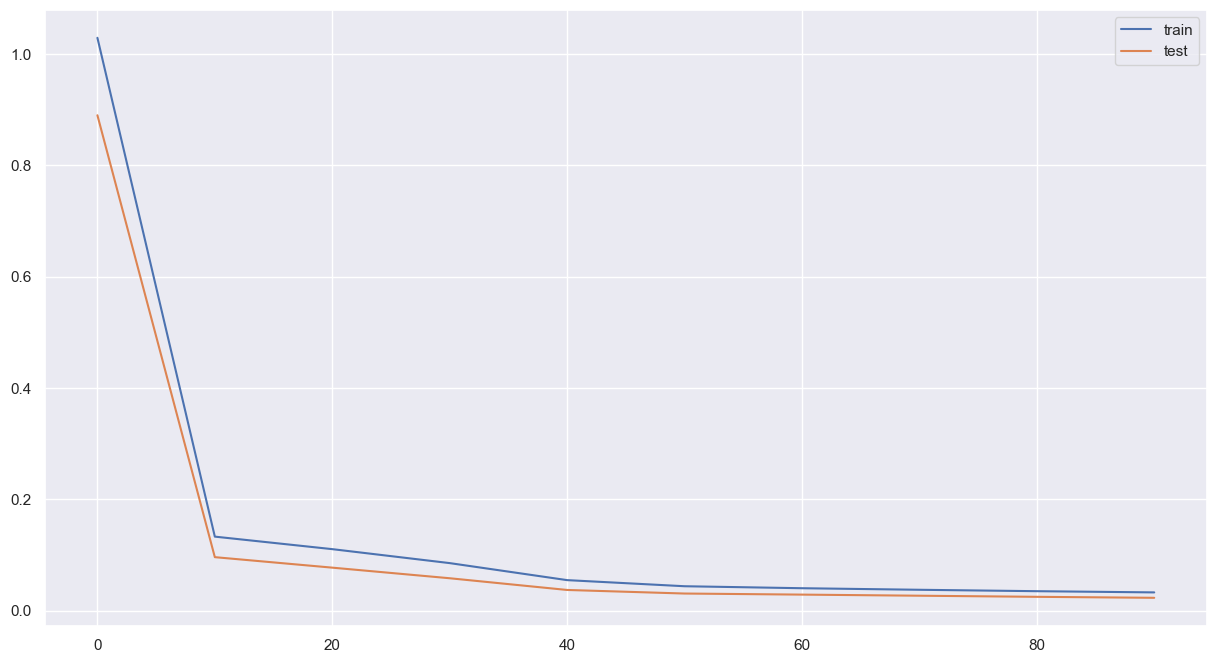

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = df.drop(['Usage_kWh'], axis=1).to_numpy()
y = df[["Usage_kWh"]].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)


lstm = LSTM(x.shape[1], x.shape[1])
losses = lstm.train(x_train, y_train, x_test, y_test, 100, 0.0001, 3)

def plot_learning_curves(losses: dict[int, list[float]]):
    plt.plot(list(losses.keys()), [loss[0] for loss in losses.values()], label="train")
    plt.plot(list(losses.keys()), [loss[1] for loss in losses.values()], label="test")
    plt.legend()
    plt.show()


plot_learning_curves(losses)

In [13]:
def r2_score(y_true, y_pred):
    numerator = np.nansum((y_true - y_pred) ** 2, axis=0, dtype=np.float64)
    denominator = np.nansum((y_true - np.nanmean(y_true, axis=0)) ** 2, axis=0, dtype=np.float64)
    return np.mean(1 - numerator / denominator)

lstm.forward(x_test[:len(x_test)])
r2_score(scaler.inverse_transform(y_test), scaler.inverse_transform(lstm.output))


0.9468437690222307

In [14]:
def RMSE(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse_val = np.sqrt(mse)
    return rmse_val

rmse = RMSE(scaler.inverse_transform(y_test), scaler.inverse_transform(lstm.output))
rmse_norm = rmse / (max(scaler.inverse_transform(y_test)) - min(scaler.inverse_transform(y_test)))
print(rmse, rmse_norm[0])


7.232997888128009 0.0460172915646266
